In [29]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, TransformerConv , global_max_pool, GINConv
from torch_geometric.transforms import ToUndirected

In [30]:
# current_file = 'C:/Users/Dell/Desktop/Summer Internship CDSAML/Untitled16.ipynb'
current_file = 'pol'

# path = osp.join(osp.dirname(osp.realpath(current_file)), '.', 'data', 'UPFD')
train_dataset = UPFD(current_file, 'politifact', 'spacy', 'train', ToUndirected())
val_dataset = UPFD(current_file, 'politifact', 'spacy', 'val', ToUndirected())
test_dataset = UPFD(current_file, 'politifact', 'spacy', 'test', ToUndirected())

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [31]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [32]:
class GraphTransformer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 concat=False):
        super().__init__()
        self.concat = concat

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = TransformerConv(hidden_channels, hidden_channels, heads=3)
        self.conv3 = TransformerConv(hidden_channels*3, hidden_channels, heads = 3, concat = False)

        if self.concat:
            self.lin0 = Linear(in_channels, hidden_channels)
            self.lin1 = Linear(2 * hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()
        h = global_max_pool(h, batch)

        if self.concat:
            # Get the root node (tweet) features of each graph:
            root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
            root = torch.cat([root.new_zeros(1), root + 1], dim=0)
            news = x[root]

            news = self.lin0(news).relu()
            h = self.lin1(torch.cat([news, h], dim=-1)).relu()

        h = self.lin2(h)
        return h.log_softmax(dim=-1), h

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphTransformer(train_dataset.num_features, 16, train_dataset.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [34]:
model.lin0.register_forward_hook(get_activation('lin0'))
activations = []

def train():
    global embeddings1
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, emb = model(data.x, data.edge_index, data.batch)

        embs = torch.mean(activation['lin0'], dim = 0)
        #print(activation['lin0'].shape)
        activations.append(activation['lin0'])

        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_loader.dataset)

In [35]:
activs = []
model.lin0.register_forward_hook(get_activation('lin0'))

@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = total_examples = 0
    for data in loader:
        # print(data.batch)
        data = data.to(device)
        #pred, emb = model(data.x, data.edge_index, data.batch).argmax(dim=-1)
        pred_tuple, emb = model(data.x, data.edge_index, data.batch)
        activs.append(activation['lin0'])
        # print("\n","Array",activation['lin2'])
        # print("Arraylen",activation['lin2'].shape)

        #embeds.append(emb)
        #print(emb)
        pred = pred_tuple.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
        total_examples += data.num_graphs

    return total_correct / total_examples

In [36]:
losses = []
trains = []
vals = []
tests = []

epochs = 200

In [37]:
for epoch in range(1, epochs):
    loss = train()
    losses.append(loss)
    train_acc = test(train_loader)
    trains.append(train_acc)
    val_acc = test(val_loader)
    vals.append(val_acc)
    test_acc = test(test_loader)
    tests.append(test_acc)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.6815, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 02, Loss: 0.6806, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 03, Loss: 0.6800, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 04, Loss: 0.6794, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 05, Loss: 0.6789, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 06, Loss: 0.6785, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 07, Loss: 0.6780, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 08, Loss: 0.6776, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 09, Loss: 0.6772, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 10, Loss: 0.6768, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 11, Loss: 0.6764, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 12, Loss: 0.6760, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 13, Loss: 0.6755, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 14, Loss: 0.6751, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 15, Loss: 0.6746, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 16,

In [38]:
for data in test_loader:
    data = data.to(device)
    df = pd.DataFrame()
    pred_tuple = model(data.x, data.edge_index, data.batch)
    pred = pred_tuple[0].detach().cpu().numpy()[:, 0]
    df['Pred_value'] = pred
    # round this to the nearest integer.
    # if the nearest integer is 0 then final prediction is 0, otherwise it's 1
    df['Final_pred'] = (df['Pred_value'] < -0.5).astype(int)
    df['True_value'] = data.y.cpu().numpy()
    print(df)
    break

df.to_csv("upfd_pred.csv")


     Pred_value  Final_pred  True_value
0     -0.074965           0           1
1     -0.745164           1           1
2     -3.206599           1           1
3     -2.355871           1           1
4     -0.001566           0           0
..          ...         ...         ...
123   -2.810791           1           1
124   -0.047220           0           1
125   -4.391593           1           1
126   -1.969422           1           0
127   -0.000066           0           1

[128 rows x 3 columns]


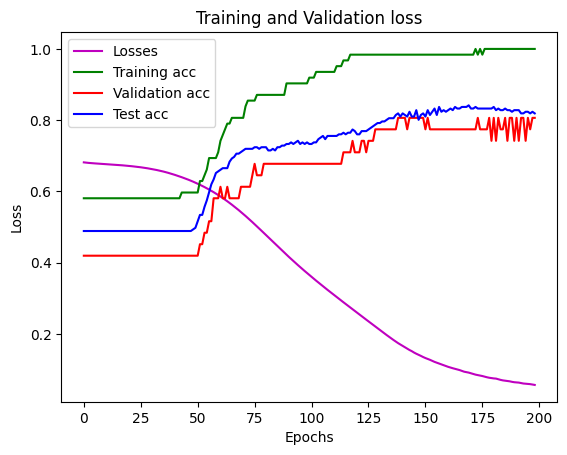

In [39]:
import matplotlib.pyplot as plt

ep = range(epochs-1)

plt.plot(ep, losses, 'm', label='Losses')
plt.plot(ep, trains, 'g', label='Training acc')
plt.plot(ep, vals, 'r', label = 'Validation acc')
plt.plot(ep, tests, 'b', label='Test acc')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
# print(activations[-1])
# print(activations[-1].shape)

# x = activations[-1].detach().numpy()
# x = pd.DataFrame(x)
# x.to_csv("main3.csv")


In [41]:
print(len(activs), len(activs[-2]))


trains1 = activs[-4]
vals1 = activs[-3]

print(activs[-2].shape, activs[-1].shape)
tests1 = torch.cat((activs[-2],activs[-1]), dim = 0)
#print(activs[-1].shape)

796 128
torch.Size([128, 16]) torch.Size([93, 16])


In [42]:
print(trains1, trains1.shape)

tensor([[ 1.1969e-01,  4.1877e-01,  1.2249e-01,  1.9518e-01,  3.8593e-03,
          1.0730e-01,  6.5618e-01,  1.3284e-01,  5.2567e-01,  5.2830e-01,
          1.6760e-01, -4.9788e-05,  5.3074e-01,  6.1610e-01,  6.6764e-01,
          1.6849e-01],
        [ 1.1981e-01,  1.3016e-01,  1.7432e-01,  6.7975e-02, -1.2286e-04,
          1.6420e-01,  2.3309e-01,  1.6484e-01,  1.8274e-01,  1.9674e-01,
          2.2262e-01, -2.7463e-05,  1.9082e-01,  1.9255e-01,  2.2673e-01,
          2.3391e-01],
        [ 1.2835e-01,  3.9870e-01,  1.4331e-01,  1.8784e-01,  2.5124e-03,
          1.0740e-01,  6.4021e-01,  1.4625e-01,  5.1678e-01,  5.1707e-01,
          1.8016e-01, -4.9826e-05,  5.1504e-01,  5.9999e-01,  6.4933e-01,
          1.7857e-01],
        [ 4.8086e-02,  4.5751e-01,  3.3916e-02,  2.0422e-01,  5.0593e-03,
          3.0330e-03,  7.3376e-01,  3.2439e-02,  5.7763e-01,  5.9405e-01,
          4.4369e-02, -4.8570e-05,  5.9660e-01,  6.9818e-01,  7.1435e-01,
          5.0540e-02],
        [ 2.8432e-02

In [43]:
print(vals1, vals1.shape)

tensor([[ 1.0350e-01,  4.3174e-01,  8.4898e-02,  1.9545e-01,  4.1678e-03,
          6.1906e-02,  6.8897e-01,  9.5520e-02,  5.4583e-01,  5.5698e-01,
          1.1440e-01, -5.7934e-05,  5.6634e-01,  6.6992e-01,  6.9162e-01,
          1.2360e-01],
        [ 5.1344e-02,  4.6743e-01,  6.1513e-02,  2.1419e-01,  4.0244e-03,
          2.4371e-02,  7.5134e-01,  5.6350e-02,  6.1248e-01,  6.1740e-01,
          6.7671e-02, -4.9978e-05,  6.1373e-01,  7.1051e-01,  7.4035e-01,
          6.1883e-02],
        [ 1.0832e-01,  3.9183e-01,  1.0991e-01,  1.8002e-01,  3.3436e-03,
          8.2728e-02,  6.1885e-01,  1.1588e-01,  5.0723e-01,  5.0476e-01,
          1.4954e-01, -5.5648e-05,  5.0913e-01,  5.9014e-01,  6.3332e-01,
          1.4884e-01],
        [ 1.2262e-01,  4.2032e-01,  1.0200e-01,  1.9075e-01,  3.9061e-03,
          5.4185e-02,  6.7373e-01,  1.1250e-01,  5.4015e-01,  5.4087e-01,
          1.3596e-01, -6.0372e-05,  5.5557e-01,  6.6036e-01,  6.8649e-01,
          1.4290e-01],
        [ 3.9016e-01

In [44]:
print(tests1, tests1.shape)

tensor([[0.2534, 0.3176, 0.2669,  ..., 0.4708, 0.5462, 0.3303],
        [0.0685, 0.4376, 0.0541,  ..., 0.6830, 0.6977, 0.0625],
        [0.1228, 0.4315, 0.1125,  ..., 0.6676, 0.7066, 0.1589],
        ...,
        [0.0623, 0.4475, 0.0515,  ..., 0.6973, 0.7211, 0.0783],
        [0.3152, 0.2155, 0.3401,  ..., 0.3124, 0.4042, 0.4487],
        [0.1135, 0.4050, 0.1149,  ..., 0.6086, 0.6531, 0.1566]]) torch.Size([221, 16])


In [45]:
#x1 = pd.DataFrame(trains1)
x1 = trains1

In [46]:
#x2 = pd.DataFrame(vals1)
x2 = vals1

In [47]:
#x3 = pd.DataFrame(tests1)
x3 = tests1

In [48]:
#x1.to_csv("main1.csv", index = False, header = False)

In [49]:
#x2.to_csv("main1.csv", mode = "a", index = False, header = False)

In [50]:
#x3.to_csv("main1.csv", mode = "a", index = False, header = False)

In [51]:
x = torch.cat((torch.cat((x1,x2), dim = 0),x3), dim = 0)

In [52]:
y1 = train_dataset.y
y2 = val_dataset.y
y3 = test_dataset.y


In [53]:
y = torch.cat((torch.cat((y1,y2), dim = 0),y3), dim = 0)

print(y)

tensor([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,

In [54]:
x.shape

torch.Size([314, 16])

In [55]:
y = y.unsqueeze(1)
y.shape

torch.Size([314, 1])

In [56]:
df = torch.cat((x,y), dim = 1)
df = pd.DataFrame(df)
# df.to_csv("16_3heads.csv", index = False)